In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Multiply, Add, Activation, LSTM,Input, Concatenate, Flatten,Reshape, BatchNormalization, Masking, Conv1D,MaxPooling1D, Dropout, concatenate, Permute,RepeatVector, merge
from keras.models import Model

from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHeadAttention

from keras import backend as K
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Prepare Data

- Clean Up N/As 
- History and Future Lag (own Function)

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data['MU'][:10] = None

data['MU'][15] = None

data

C:\Users\tobia\AppData\Local\conda\conda\envs\Time\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\tobia\AppData\Local\conda\conda\envs\Time\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,AKS,BAC,CLF,CTL,ET,MS,MU,NFX,PBR,SKX
0,2017-01-03,10.54,21.779140,8.555229,20.231129,16.380995,41.021313,NaN,42.160000,10.724895,24.889999
1,2017-01-04,11.11,22.185143,8.803638,20.334877,16.722797,41.564457,NaN,42.490002,10.695187,25.610001
2,2017-01-05,10.88,21.924143,8.664530,20.350840,16.731340,41.183304,NaN,42.980000,10.992275,25.219999
3,2017-01-06,10.72,21.924143,8.416120,20.255070,16.970608,41.783615,NaN,42.970001,10.764507,25.030001
4,2017-01-09,10.31,21.798471,8.376374,20.135357,16.167364,40.697342,NaN,42.320000,10.724895,25.150000
5,2017-01-10,11.05,22.175476,9.330268,20.111420,16.013552,41.030857,NaN,41.610001,10.913053,25.620001
6,2017-01-11,11.02,22.301144,9.727723,20.143341,16.090458,41.612099,NaN,42.150002,11.428003,25.240000
7,2017-01-12,9.87,22.156145,9.469377,20.095455,16.064823,41.573994,NaN,42.500000,11.378489,25.510000
8,2017-01-13,9.71,22.243143,9.171285,20.159302,15.893919,41.745514,NaN,41.900002,11.210139,25.459999
9,2017-01-17,9.45,21.315136,9.101730,20.326895,15.842651,40.163727,NaN,42.110001,11.160625,25.270000


In [4]:
data = data.interpolate(limit_direction='both', limit_area='inside')

data = data.fillna(0)

data

,Date,AKS,BAC,CLF,CTL,ET,MS,MU,NFX,PBR,SKX
0,2017-01-03,10.54,21.779140,8.555229,20.231129,16.380995,41.021313,0.000000,42.160000,10.724895,24.889999
1,2017-01-04,11.11,22.185143,8.803638,20.334877,16.722797,41.564457,0.000000,42.490002,10.695187,25.610001
2,2017-01-05,10.88,21.924143,8.664530,20.350840,16.731340,41.183304,0.000000,42.980000,10.992275,25.219999
3,2017-01-06,10.72,21.924143,8.416120,20.255070,16.970608,41.783615,0.000000,42.970001,10.764507,25.030001
4,2017-01-09,10.31,21.798471,8.376374,20.135357,16.167364,40.697342,0.000000,42.320000,10.724895,25.150000
5,2017-01-10,11.05,22.175476,9.330268,20.111420,16.013552,41.030857,0.000000,41.610001,10.913053,25.620001
6,2017-01-11,11.02,22.301144,9.727723,20.143341,16.090458,41.612099,0.000000,42.150002,11.428003,25.240000
7,2017-01-12,9.87,22.156145,9.469377,20.095455,16.064823,41.573994,0.000000,42.500000,11.378489,25.510000
8,2017-01-13,9.71,22.243143,9.171285,20.159302,15.893919,41.745514,0.000000,41.900002,11.210139,25.459999
9,2017-01-17,9.45,21.315136,9.101730,20.326895,15.842651,40.163727,0.000000,42.110001,11.160625,25.270000


In [5]:
for c in data.columns:
    scaler = []
    if c != 'Date':
        sc = MinMaxScaler()
        scaler.append(sc.fit(data[[c]]))
        data[c] = sc.transform(data[[c]])

In [6]:
def transformData(data, pastlag, futurelag = 1, validation_span = 16, arraylength = None):

    if arraylength is None:
        arraylength = pastlag
    cols = []
    past_train = []
    future_train  = []
    past_validate = []
    future_validate  = []
    for c in data.columns:
        if c != 'Date':
            cols.append(c)

    for c in cols:    
        ar = np.asarray(data[c])
        l = len(ar)
        iv = (l-futurelag) - validation_span
        #iv = pastlag + int(((l-futurelag)-pastlag)*(1-validation_percentage))
        for i in range(pastlag,len(ar)-futurelag + 1):
            if i <= iv:
                for j in range(futurelag):
                    if i-arraylength < 0:
                        p_ar = ar[0:i]
                        p_ar = np.pad(p_ar,(arraylength - len(p_ar),0),'constant')
                    else:
                        p_ar = ar[i-arraylength:i]
                    past_train.append(p_ar)
                    #future_train.append(ar[i:i+futurelag])
                    future_train.append(ar[i+j:i+j+1])
            else:
                for j in range(futurelag):
                    if i-arraylength < 0:
                        p_ar = ar[0:i]
                        p_ar = np.pad(p_ar,(arraylength - len(p_ar),0),'constant')
                    else:
                        p_ar = ar[i-arraylength:i]
                    past_validate.append(p_ar)
                    future_validate.append(ar[i+j:i+j+1])
                    #future_validate.append(ar[i:i+futurelag])
    return np.asarray(past_train), np.asarray(future_train), np.asarray(past_validate), np.asarray(future_validate)

In [7]:
def transformDataByCols(data, pastlag, targetCol, ExoCols = [], futurelag = 1, validation_span = 24, arraylength = None):

    if arraylength is None:
        arraylength = pastlag
    past_train = []
    future_train  = []
    past_validate = []
    future_validate  = []
    
    cols = [targetCol] + ExoCols
    for c in cols: 
        p_t_c =  []
        f_t_c = []
        p_v_c = []
        f_v_c  = []
        ar = np.asarray(data[c])
        l = len(ar)
        iv = (l-futurelag) - validation_span
        #iv = pastlag + int(((l-futurelag)-pastlag)*(1-validation_percentage))
        for i in range(pastlag,len(ar)-futurelag+1):
            if i <= iv:
                if i-arraylength < 0:
                        p_ar = ar[0:i]
                        p_ar = np.pad(p_ar,(arraylength - len(p_ar),0),'constant')
                else:
                        p_ar = ar[i-arraylength:i]
                p_t_c.append(p_ar)
                f_t_c.append(ar[i:i+futurelag])
            else:
                if i-arraylength < 0:
                        p_ar = ar[0:i]
                        p_ar = np.pad(p_ar,(arraylength - len(p_ar),0),'constant')
                else:
                        p_ar = ar[i-arraylength:i]
                p_v_c.append(p_ar)
                f_v_c.append(ar[i:i+futurelag])
        
        past_train.append(np.expand_dims(np.asarray(p_t_c),-1))
        past_validate.append(np.expand_dims(np.asarray(p_v_c),-1))
        if  c == targetCol:
            future_train = np.asarray(f_t_c)
            future_validate = np.asarray(f_v_c)
                
                
    return past_train, future_train, past_validate, future_validate

In [8]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback


def RMSEperLag(x_true,x_pred):
    return np.sqrt(np.mean((x_true - x_pred)**2,axis= 0))



class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        
    def on_epoch_start(self,epoch, logs={}):
        
        K.set_value(self.model.optimizer.lr, lr)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            
            
            score = RMSEperLag(self.y_val, y_pred)
            
            for s in score:
                print(s)
            #print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, score))

    
class LRRestart(Callback):
    def __init__(self, maxLR, maxEpoch, patience, minLR = 0.1e-5):
        super(Callback, self).__init__()
        self.maxLR = maxLR    
        self.patience = patience
        self.minLR = minLR
        self.restart = True
        self.lastRestartEpoch = 1
        self.best_val_loss = None
        self.wait = 0 
        
    def schedule(epoch):
        reductionRate = ((self.maxLR - self.MinLR)/self.maxEpoch) / self.maxLR
        lr = self.maxLR - (epoch - lastRestartEpoch) *max(reductionRate*self.maxLR, self.minLR)
        return lr
    
    def on_training_begin(self, logs ={}):
        
        self.wait = 0
        
    def on_epoch_start(self,epoch, logs=None):
            
        if self.restart or (epoch - self.lastRestartEpoch) > self.maxEpoch:
            self.lastRestartEpoch = epoch
            self.restart = False
        lr = schedule(epoch)
            
        K.set_value(self.model.optimizer.lr, lr)
        
    def on_epoch_end(self, epoch,logs = None):
            
            logs = logs or {}
            logs['lr'] = K.get_value(self.model.optimizer.lr)
            
            self.current_val_loss = logs.get('val_loss')
            
            if self.best_val_loss is None:
                self.best_val_loss = self.current_val_loss
            
            if self.current_val_loss < self.best_val_loss:
                self.best_val_loss = self.current_val_loss 
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.restart = True
                    #self.model.stop_training = True
                    
class UnfreezeLayer(Callback):
    def __init__(self, layerNames = [], unfreezeSchedule = []):
        super(Callback, self).__init__()
        self.layerNames = layerNames    
        self.unfreezeSchedule = unfreezeSchedule
        
    def on_epoch_start(self,epoch, logs=None):
        
        for i, u in enumerate(self.unfreezeSchedule):
            if u == epoch:
                for ln in  [l.name for l in g_lstm.layers if layerNames[u] + '.' in l.name ]:
                    self.model.get_layer(ln).trainable = True

In [9]:
from keras.layers.core import Lambda
from keras import backend as K

def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

def expand_dims(x):
    return K.expand_dims(x,1)
def expand_dims_output_shape(input_shape):
    return (input_shape[0],1,input_shape[1])

In [135]:
past_t, future_t, past_v, future_v  = transformData(data,pastlag = 90, futurelag = 1, arraylength   = 90)

## General LSTM Model

- define Model
- Train Model on all Data 
- save trained weights


layer_conv_1d(filters=64, kernel_size=4, activation="relu", input_shape=c(lookback, dim(dm)[[-1]])) %>%
  layer_max_pooling_1d(pool_size=4) %>%
  layer_flatten() %>%
  layer_dense(units=lookback * dim(dm)[[-1]], activation="relu") %>%
  layer_dropout(rate=0.2) %>%
  layer_dense(units=1, activation="linear")

In [136]:
#### DECODER MODEL
decoder = Sequential()
dec_input = Input((90,1))
#dec_batchNorm = BatchNormalization()(dec_input)
dec_batchNorm = dec_input
### Conv

dec_conv = Conv1D(8,3,activation="relu")(dec_batchNorm)
dec_pool = MaxPooling1D(2)(dec_conv)
dec_conv2 = Conv1D(4,5,activation="relu")(dec_pool)
dec_pool2 = MaxPooling1D(4)(dec_conv)
dec_pool2 = SeqSelfAttention(attention_activation='sigmoid')(dec_pool2) 
dec_conv_flat = Flatten()(dec_pool2)
dec_conv_flat = Dropout(0.2)(dec_conv_flat)

### LSTM 
dec_attention = SeqSelfAttention(attention_activation='sigmoid')(dec_batchNorm) 
dec_lstm = LSTM(10,dropout = 0.5 ,return_sequences = False)(dec_attention)
#dec_attention = SeqSelfAttention(attention_activation='sigmoid')(dec_lstm) 
#dec_lstm_flat = Flatten()(dec_attention)
dec_lstm_flat = dec_lstm


dec_output = concatenate([dec_conv_flat, dec_lstm_flat],axis = -1)
#dec_output = dec_lstm_flat
#dec_output = dec_conv_flat

decoder = Model(dec_input,dec_output)

g_lstm = Sequential()
g_lstm.add(decoder)
#g_lstm.add(Dense(90*4, activation="relu"))
#g_lstm.add(Dropout(0.2))
#g_lstm.add(Dense(30, name = 'glstm_dense'))
g_lstm.add(Dense(1))



In [137]:
g_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_19 (Model)             (None, 186)               1218      
_________________________________________________________________
dense_425 (Dense)            (None, 1)                 187       
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________


In [138]:

g_lstm.compile(loss = 'mse',optimizer = 'adam')
ival = IntervalEvaluation(validation_data =(np.expand_dims(past_v,-1),future_v), interval=1)
lrre = LRRestart(maxLR = .5, maxEpoch = 10, patience = 5)

g_lstm.fit(np.expand_dims(past_t,-1), future_t, batch_size = 200, epochs=50, validation_data = (np.expand_dims(past_v,-1),future_v), 
           #callbacks=[lrre],
           verbose = 1)

Train on 1450 samples, validate on 160 samples
Epoch 1/50
1450/1450 [==============================] - 52s 36ms/step - loss: 0.0860 - val_loss: 0.1411
Epoch 2/50
1450/1450 [==============================] - 14s 9ms/step - loss: 0.0605 - val_loss: 0.0917
Epoch 3/50
1450/1450 [==============================] - 15s 10ms/step - loss: 0.0498 - val_loss: 0.0681
Epoch 4/50
1450/1450 [==============================] - 14s 10ms/step - loss: 0.0476 - val_loss: 0.0632
Epoch 5/50
1450/1450 [==============================] - 15s 10ms/step - loss: 0.0479 - val_loss: 0.0654
Epoch 6/50
1450/1450 [==============================] - 15s 10ms/step - loss: 0.0462 - val_loss: 0.0711
Epoch 7/50
1450/1450 [==============================] - 14s 10ms/step - loss: 0.0451 - val_loss: 0.0729
Epoch 8/50
1450/1450 [==============================] - 14s 9ms/step - loss: 0.0453 - val_loss: 0.0733
Epoch 9/50
1450/1450 [==============================] - 16s 11ms/step - loss: 0.0450 - val_loss: 0.0719
Epoch 10/50
1450/14

In [ ]:
g_lstm.save('glstm.h5')

In [41]:
predA = decoder.predict(np.expand_dims(past_t,-1))

## Estimate with Exogenen Variables

- Embedding of  each TS with general  LSTM
- Multi Attettion Head over all TS
- Estimate Full future timespan

Train Model first with froozen LSTM Layer... unfreeze later in training

In [114]:

EXO = ["BAC", "MU","AKS","CLF","SKX","PBR","NFX","MS","CTL"]
past_t, future_t, past_v, future_v  = transformDataByCols(data,targetCol = "ET", ExoCols = EXO, pastlag = 90, futurelag = 16, arraylength =90)

In [115]:
def attention_3d_block(inputs,TIME_STEPS, SINGLE_ATTENTION_VECTOR ):

    # inputs.shape = (batch_size, time_steps, input_dim)

    input_dim =186# int(inputs.shape[2])

    a = Permute((2, 1))(inputs)

    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.

    a = Dense(TIME_STEPS, activation='softmax')(a)

    if SINGLE_ATTENTION_VECTOR:

        a = Lambda(lambda x: K.mean(x, axis=1))(a)

        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)

    output_attention_mul = Multiply()([inputs, a_probs])#, name='attention_mul', mode='mul')

    return output_attention_mul

In [132]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate


in_in = []
out_in = []

#bb = BatchNormalization()


decoder.trainable = False

#a_layer = SeqSelfAttention(attention_activation='sigmoid', name = 'att.0', weights = glstm_a_weights)
#a_layer.trainable = False
for i in range(len(EXO)+1):
    inp = Input((90,1))
    in_in.append(inp)  
    a = decoder(inp)
    #a = concatenate([a,Flatten()(inp)],axis=-1)
    a= Lambda(expand_dims, expand_dims_output_shape)(a)
    out_in.append(a)
        

if len(EXO) >= 1:
    out_dec=concatenate(out_in,axis=1)
else:
    out_dec = out_in
    
#out_dec = BatchNormalization()(out_dec)
out_ar = []    

#out_dec = MultiHeadAttention(head_num=5)(out_dec)

#out = attention_3d_block(out_dec, len(EXO) + 1, False)

for  j in range(16):
    #out = attention_3d_block(out_dec, len(EXO) + 1, True)
    #out = SeqSelfAttention(attention_activation='sigmoid')(out_dec)

    #out = MultiHeadAttention(
    #    head_num=5)(out_dec)
    out= Dropout(0.2)(out_dec)
    out = Flatten()(out)
    out = Dense(20, activation = "relu")(out)
    out= Dropout(0.2)(out)

#out = Dense(30)(out)
    out = Dense(1)(out)
    out_ar.append(out)
    
oo = concatenate(out_ar,axis = -1)
'''
o2 = attention_3d_block(out_dec, len(EXO), False)
o2 = Flatten()(o2)
o2 = Dense(16)(o2)
ooo = Add()([oo,o2])
'''
model = Model(inputs = in_in, outputs = [oo])


In [133]:
def weighted_mse(yTrue,yPred):
    ones = K.ones_like(yTrue[0,:])
    idx = K.cumsum(ones)
    
    return K.mean((1/idx)*K.square(yTrue- yPred))

In [134]:
model.compile(loss = 'mse',optimizer = 'adam')

#ival = IntervalEvaluation(validation_data =(past_v,future_v), interval=1)
lrre = LRRestart(maxLR = .5, maxEpoch = 10, patience = 5)
unfreeze = UnfreezeLayer(['lstm'], [20])

model.fit(past_t, future_t, batch_size = 32, epochs=30, validation_data = (past_v,future_v))#, callbacks = [lrre,unfreeze])

Train on 122 samples, validate on 24 samples
Epoch 1/30
122/122 [==============================] - 42s 342ms/step - loss: 0.2362 - val_loss: 0.1374
Epoch 2/30
122/122 [==============================] - 1s 9ms/step - loss: 0.1051 - val_loss: 0.0430
Epoch 3/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0800 - val_loss: 0.0441
Epoch 4/30
122/122 [==============================] - 1s 11ms/step - loss: 0.0622 - val_loss: 0.0578
Epoch 5/30
122/122 [==============================] - 1s 10ms/step - loss: 0.0605 - val_loss: 0.0662
Epoch 6/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0589 - val_loss: 0.0544
Epoch 7/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0521 - val_loss: 0.0568
Epoch 8/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0507 - val_loss: 0.0551
Epoch 9/30
122/122 [==============================] - 1s 9ms/step - loss: 0.0473 - val_loss: 0.0462
Epoch 10/30
122/122 [=============================

In [ ]:
model.summary()

In [120]:
predA = model.predict(past_v)

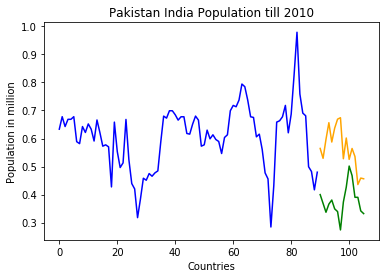

In [125]:
%matplotlib inline
I =10

import matplotlib.pyplot as plt
past= np.squeeze(past_v[0][I])
future= future_v[I]
past_x =[i for i in range(len(past))]
future_x =[i for i in range(len(past),len(past)+len(future))]
pred = predA[I]


#pop_india = [449.48, 553.57, 696.783, 870.133, 1000.4, 1309.1]
plt.plot(past_x, past, color='blue')
plt.plot(future_x, future, color='g')
plt.plot(future_x, pred, color='orange')
plt.xlabel('Countries')
plt.ylabel('Population in million')
plt.title('Pakistan India Population till 2010')
plt.show()

In [ ]:
past_t, future_t, past_v, future_v  = transformDataByCols(data,targetCol = "IWM", ExoCols = [], pastlag = 30)
t_lstm = Sequential()

t_lstm.add(LSTM(20, dropout=0.2, name = 'glstm'))
t_lstm.add(Dense(1, name = 'glstm_dense'))

In [ ]:
t_lstm.compile(loss = 'mse',optimizer = 'adam')
t_lstm.fit(past_t, future_t, batch_size = 10, epochs=100, validation_data = (past_v,future_v), verbose = 2)